# All 0-9 Integer recognition - Attempt 01

Expectation: Recognize digits 0-9 distinctively with a ML code entirely implemented by me from the scratch<br/>


### Importing libraries

In [1]:
import cv2 as cv
import time
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.signal as sig
import pprint
import json
import scipy.stats as scistat
import random

#### Drawing and saving the data set

In [4]:
base = r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/"

while 1:
    imgNew = cv.imread(base+"1.png",0);
    if imgNew is None:
        continue
    imgLast = cv.imread(base+"2.png",0);
    
    if (not(imgNew==imgLast).all()):
        cv.imwrite(base+"2.png",imgNew)
        cv.imwrite(base + str(time.time()) + ".png",imgNew)
    time.sleep(0.5)

        
        

KeyboardInterrupt: 

In [2]:
dataFolderC = r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/circle/"
dataFilesC = os.listdir(dataFolderC)

dataFolderR = r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/rect/"
dataFilesR = os.listdir(dataFolderR)

dataFolders = [  ["0",r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/0/"],
                 ["1",r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/1/"],
                 ["2",r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/2/"],
                 ["3",r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/3/"],
                 ["4",r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/4/"],
                 ["5",r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/5/"],
                 ["6",r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/6/"],
                 ["7",r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/7/"],
                 ["8",r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/8/"],
                 ["9",r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/9/"]
              ]

### Remove empty-whitespace arround an image by zooming to the content

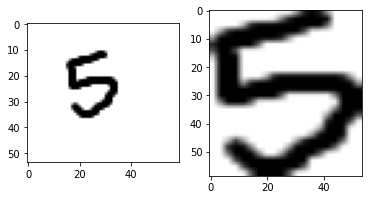

In [3]:
def focusToContent(img):
    img_ = 255*(img < 128).astype(np.uint8) 
    coords = cv.findNonZero(img_) # Find all non-zero points (text)
    x, y, w, h = cv.boundingRect(coords) # Find minimum spanning bounding box
    
    rect = img[y:y+h, x:x+w] # Crop the image - note we do this on the original image
    rect_originalSized = cv.resize(rect,(img.shape))
    return rect_originalSized
    

#testing
img = cv.imread(r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/test/1650009171.5083215.png",0)
assert img is not None
focused = focusToContent(img)

fig,ax = plt.subplots(1,2)
ax[0].imshow(img,cmap="gray")
ax[1].imshow(focused,cmap="gray")

### Generating random kernels/filters to detect basic shapes from data images

also saving them as JSON as back up

In [4]:
ksizeChoises =[3,3,5,7]
kernelCount = 100
cmap="gray"

filters = []
tries =0
while len(filters) < kernelCount:
    ksize = random.choice(ksizeChoises)
    tries += 1
    testKernel = np.random.rand(ksize,ksize)
    testKernel -= np.mean(testKernel)
    testKernel = 2*np.array(testKernel > 0,np.float32) 
    testKernel -= 1
    testKernel[testKernel.shape[0]//2,testKernel.shape[1]//2] -= np.sum(testKernel)
    
    #checking if this kernel already in the filters array
    isUnique =1
    for filter in filters:
        if filter.shape == testKernel.shape and np.all(filter==testKernel):
            isUnique = 0
    if isUnique:
        filters.append(testKernel)

        
#saving filters as json 
filtersJsonFolder = "D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/Image-processing-fundamentals/integer-rec/"
filtersAsArrays = [] #because numpy arrays cannot be converted to JSON obj
for filter in filters:
    filtersAsArrays.append(filter.tolist())
f=open(filtersJsonFolder + str(time.time()) + ".txt","w")
f.write(json.dumps(filtersAsArrays))
f.close()

print("tried ",tries," times to generate ", kernelCount, " unique Kernels")

tried  106  times to generate  100  unique Kernels


### Feature threshold values
After filtering, the results should be cleaned. So the non-dominant activations will be zeroed using these thresholds.


In [5]:
featureTresVals = [0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,0.99]
#featureTresVals = [0.9,0.95,0.99] #to make it simplified

print("No. of Feature threshold values:",len(featureTresVals))

No. of Feature threshold values: 11


## Training for "2" or  "4"


In [6]:
# trainingDataFileFolder = dataFolderC
# trainingFiles = dataFilesC
# dataFileCount = len(trainingFiles)

# trainingDataFileFolder_negative = dataFolderR
# trainingFiles_negative = dataFilesR
# dataFileCount_negative = len(trainingFiles_negative)


### Parameters 
There are $N_k$ kernels and $N_t$ threshold  values, resulting in $N_kN_t$ processes.<br/>
Let result from one of those process be $R_{ij}$ ; $i = kernel\ index$ and $j = threshold\ index$ 
<br/>
Output should be a weighted sum of all process results ($R_{ij}$)
<br/>
Those weights are the parameters, which are changed to minimize the error
<br/>
As $R_{ij}$ are 2D, these parameters $\alpha_{ij}$ also are 2D
<br/>
In this "params" variable, all the 2D-parameters are saved as a matrix.So variable param is a 4D-array.


<hr/>

First the initial parameters are generated/guessed as the averageZeroed normalized average of all the results (per process).<br/>
Which is better than starting from a random 2D array!

### Initializing param

params_ALL  contains all the parameters (averages) for each data set
<br/>
Therefore, params_ALL\[classIndex][kernelIndex][ThresholdIndex] will be a 2D-parameter image

In [7]:
params_ALL =[]

In [8]:
for dataSetIndex in range(len(dataFolders)):
    trainingDataFileFolder = dataFolders[dataSetIndex][1]
    trainingFiles = os.listdir(trainingDataFileFolder)
    dataFileCount = len(trainingFiles)
    
    #initial parameters are generated/guessed as the normalized average of all the results (per process)
    params = []
    for filterIndex in range(len(filters)):
        thisFilter = filters[filterIndex]
        parameterArrayForThisKernel =[]
        for featureTres in featureTresVals:
            avgForProcess = 0 #will be a 2D image (average)
            for fileIndex in range(len(trainingFiles)):
                filePath = trainingDataFileFolder + trainingFiles[fileIndex]
                dataImg = cv.imread(filePath,0)
                assert dataImg is not None
                dataImg = focusToContent(dataImg)
                dataImg = dataImg.astype(np.float32)

                filtered = cv.filter2D(dataImg,-1,thisFilter)
                thresholderMask = filtered > np.max(filtered) * featureTres
                thresholdedResult = filtered*thresholderMask


                if not fileIndex:
                    avgForProcess = thresholdedResult/dataFileCount
                else:
                    avgForProcess += thresholdedResult/dataFileCount

            avgForProcess /= np.sum(avgForProcess) #normalizing
            avgForProcess -= np.mean(avgForProcess) #mean zeroing
            parameterArrayForThisKernel.append(avgForProcess)
        params.append(parameterArrayForThisKernel)    
    params_ALL.append(params)

In [9]:
params[0][0][50][4]

-0.00020617603

### Fine tuning "params" the 4D array
"prams" has $N_k$ X $N_t$ X $h_{data}$ X $w_{data}$  parameters
<br/>
Only for each process, each 2D_parameter will be scaled. That is; their distribution is only depending on the average of results.


In [10]:
corrTres = 0.001

In [126]:

alpha = 0

print("total processes", len(filters)*len(featureTresVals))

for fileIndex in range(len(trainingFiles)):
    paramRes = []
    filePath = trainingDataFileFolder + trainingFiles[fileIndex]
    dataImg = cv.imread(filePath,0)
    assert dataImg is not None
    dataImg = focusToContent(dataImg)
    dataImg = dataImg.astype(np.float32)
    
    #r3ki3g
    #dataImg = cv.GaussianBlur(dataImg,(5,5),4) #blured after seeing the feature-detection-filtering
    
    for filterIndex in range(len(filters)):
        corrsForThisFilter =[]
        thisFilter = filters[filterIndex]
        parameterArrayForThisKernel =[]
        for featureTresIndex in range(len(featureTresVals)):
            featureTres = featureTresVals[featureTresIndex]

            #the parameter (2D) for this process (consisting by this kernel and treshold)
            parameter2D = params[filterIndex][featureTresIndex] #normalized,averageZeroed
            #r3ki3g
            parameter2D = cv.GaussianBlur(parameter2D,(7,7),4)
        
            
            filtered = cv.filter2D(dataImg,-1,thisFilter)
            #r3ki3g
            filtered = cv.GaussianBlur(filtered,(5,5),4)
            thresholderMask = filtered > np.max(filtered) * featureTres
            thresholdedResult = filtered*thresholderMask
            thresholdedResultNorm = thresholdedResult / np.sum(thresholdedResult)#normalizing
            thresholdedResultNormAVGZERO = thresholdedResultNorm - np.mean(thresholdedResultNorm) #averageZeroing
            correlation = np.sum(thresholdedResultNormAVGZERO*parameter2D)
            #print(correlation)
            corrsForThisFilter.append(correlation)
        paramRes.append(corrsForThisFilter)
        
    npParamRes = np.array(paramRes)
    dominant = np.logical_and(npParamRes > 0,npParamRes>corrTres)
    
#     fig,ax = plt.subplots()
#     ax.imshow(dataImg,cmap=cmap)
#     ax.set_title(str(np.sum(dominant)))
#     plt.show()
    
    
    #print("activations:",fileIndex,":",np.sum(dominant))
    #should add some essence of this dataimage_filteredresult to the non-dominant parameters (so it will be more corelated and dominant next time)
    if 1:
        for filterIndex in range(len(filters)):
            for featureTresIndex in range(len(featureTresVals)):
                if not dominant[filterIndex,featureTresIndex]:
                    #add essence to params
                    filtered = cv.GaussianBlur(filtered,(9,9),4)
                    thresholderMask = filtered > np.max(filtered) * featureTres
                    thresholdedResult = filtered*thresholderMask
                    thresholdedResultNorm = thresholdedResult / np.sum(thresholdedResult)#normalizing
                    thresholdedResultNormAVGZERO = thresholdedResultNorm - np.mean(thresholdedResultNorm)
                    params[filterIndex][featureTresIndex] += (thresholdedResultNormAVGZERO * alpha / dataFileCount)

           
        

total processes 1100


C:\Users\R3KI3G\AppData\Local\Temp/ipykernel_12920/4030155788.py:61: RuntimeWarning: invalid value encountered in true_divide
  thresholdedResultNorm = thresholdedResult / np.sum(thresholdedResult)#normalizing


In [17]:
print("total params",len(paramRes))
npParamRes = np.array(paramRes)

np.sum(npParamRes <0)

NameError: name 'paramRes' is not defined

### Good processes for each class

In [11]:
goodProcesses_ALL =[]
isGoodProcess_ALL = []

In [12]:
propotionNeededToSayATriggableProcess = 0.8

for dataSetIndex in range(len(dataFolders)):
    trainingDataFileFolder = dataFolders[dataSetIndex][1]
    trainingFiles = os.listdir(trainingDataFileFolder)
    dataFileCount = len(trainingFiles)
    

    goodProcesses = [] # kernel and tres value

    isGoodProcess  = [];#matrix of all kernel X tres

    for filterIndex in range(len(filters)):
        corrsForThisFilter =[]
        thisFilter = filters[filterIndex]
        parameterArrayForThisKernel =[]
        goodOrBadThisFilterForeachTres = []
        for featureTresIndex in range(len(featureTresVals)):
            featureTres = featureTresVals[featureTresIndex]
            scoreThisProcess = 0
            #the parameter (2D) for this process (consisting by this kernel and treshold)
            parameter2D = params[filterIndex][featureTresIndex] #normalized,averageZeroed
            #r3ki3g
            parameter2D = cv.GaussianBlur(parameter2D,(7,7),4)

            for fileIndex in range(len(trainingFiles)):

                filePath = trainingDataFileFolder + trainingFiles[fileIndex]
                dataImg = cv.imread(filePath,0)
                assert dataImg is not None
                dataImg = focusToContent(dataImg)
                dataImg = dataImg.astype(np.float32)

                #r3ki3g
                #dataImg = cv.GaussianBlur(dataImg,(5,5),4) #blured after seeing the feature-detection-filtering


                filtered = cv.filter2D(dataImg,-1,thisFilter)
                #r3ki3g
                filtered = cv.GaussianBlur(filtered,(5,5),4)
                thresholderMask = filtered > np.max(filtered) * featureTres
                thresholdedResult = filtered*thresholderMask
                thresholdedResultNorm = thresholdedResult / np.sum(thresholdedResult)#normalizing
                thresholdedResultNormAVGZERO = thresholdedResultNorm - np.mean(thresholdedResultNorm) #averageZeroing
                correlation = np.sum(thresholdedResultNormAVGZERO*parameter2D)
                if correlation>corrTres:

                    scoreThisProcess+=1
            #print("score",scoreThisProcess)
            requirementToGoodProcess = scoreThisProcess > propotionNeededToSayATriggableProcess * len(trainingFiles)
            goodOrBadThisFilterForeachTres.append(requirementToGoodProcess)
            if requirementToGoodProcess:
                goodProcesses.append([thisFilter,featureTres])

        isGoodProcess.append(goodOrBadThisFilterForeachTres)
    
    goodProcesses_ALL.append(goodProcesses)
    isGoodProcess_ALL.append(isGoodProcess)
    






In [13]:
isGoodProcess_ALL  

[[[False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False],
  [False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False],
  [False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False],
  [False, False, False, False, False, False, False, True, True, True, True],
  [False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False],
  [False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False],
  [False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False],
  [False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False],
  [False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False],
  [False,
   False,
   False,
   Fa

Now "isGoodProcess_ALL" have the all the (kernel,tres) status whether good or not for each dataset (class). That is only by seen the activation for positives.

<br/>
Should also find the deactivation for negatives and combine to get the best (kernel,tres) set!<hr/>
<b>Best process : Only activates for that single class only<b/>

### Making the array of isBestProcesses_ALL ; 
All and only suitable (kernel,tres) found will be in this array<br/>
This has "whether uniquely triggering process" matrix for each dataset.


In [14]:
isBestProcesses_ALL = []
for dataSetIndex in range(len(dataFolders)):
    tempOR_forAllOtherDataSets = 0
    unset = 1
    for test_dataSetIndex in range(len(dataFolders)):
        if dataSetIndex != test_dataSetIndex:
            if unset:
                tempOR_forAllOtherDataSets = isGoodProcess_ALL[test_dataSetIndex]
                unset=0
            else:
                tempOR_forAllOtherDataSets = np.logical_and(tempOR_forAllOtherDataSets,isGoodProcess_ALL[test_dataSetIndex])
    isBestProcesses = np.logical_and(np.logical_not(tempOR_forAllOtherDataSets),isGoodProcess_ALL[dataSetIndex])
    isBestProcesses_ALL.append(isBestProcesses)

In [15]:
for dataSetIndex in range(len(dataFolders)):
    isBestProcesses = isBestProcesses_ALL[dataSetIndex]
    print("dataset / class ", dataFolders[dataSetIndex][0]," :: No. of best processes:" , np.sum(isBestProcesses))

dataset / class  0  :: No. of best processes: 16
dataset / class  1  :: No. of best processes: 0
dataset / class  2  :: No. of best processes: 3
dataset / class  3  :: No. of best processes: 3
dataset / class  4  :: No. of best processes: 0
dataset / class  5  :: No. of best processes: 0
dataset / class  6  :: No. of best processes: 0
dataset / class  7  :: No. of best processes: 0
dataset / class  8  :: No. of best processes: 1
dataset / class  9  :: No. of best processes: 46


### Drawing some testing images (freezed as not always used)

In [28]:
base = r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/test-cr/"

while 1:
    imgNew = cv.imread(base+"1.png",0);
    if imgNew is None:
        continue
    imgLast = cv.imread(base+"2.png",0);
    
    if (not(imgNew==imgLast).all()):
        cv.imwrite(base+"2.png",imgNew)
        cv.imwrite(base + str(time.time()) + ".png",imgNew)

        
        

KeyboardInterrupt: 

### Testing phase
<span class="mark">set testing data folder correctly</span>

#### Testing with positives

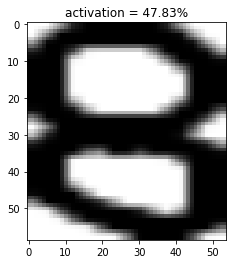

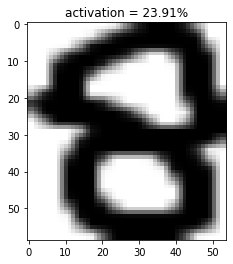

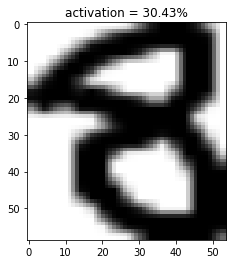

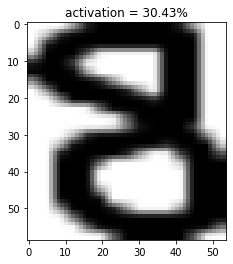

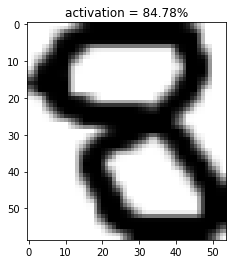

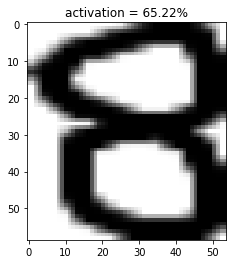

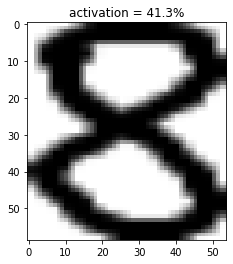

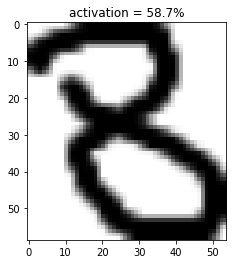

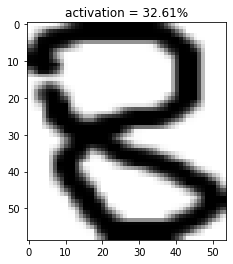

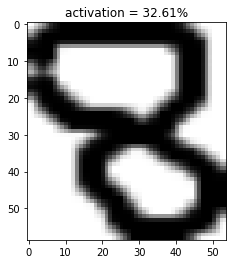

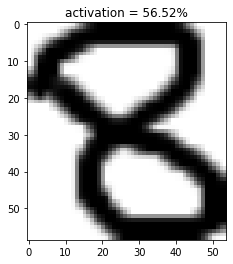

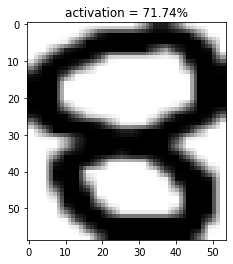

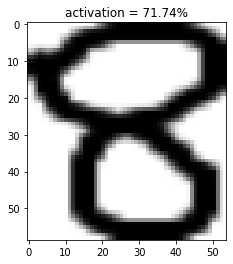

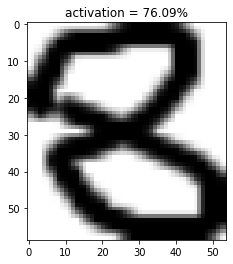

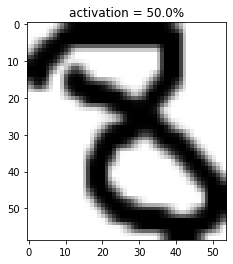

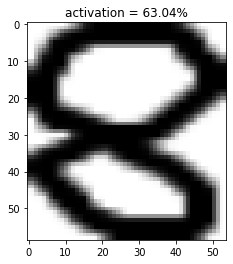

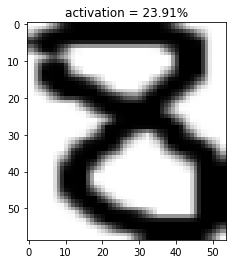

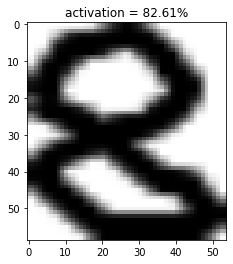

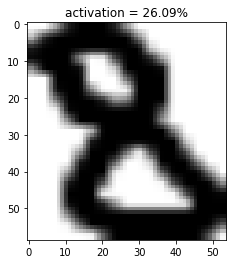

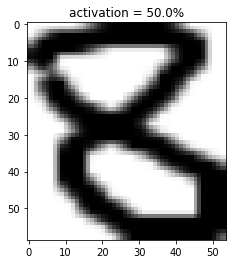

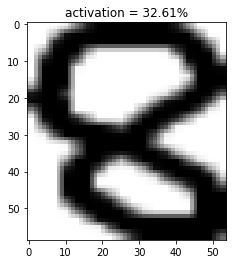

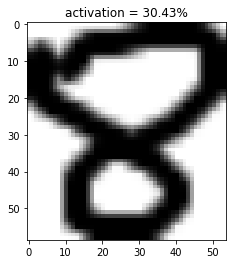

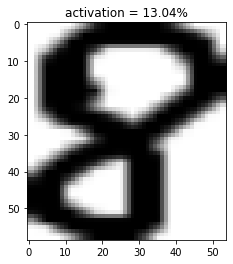

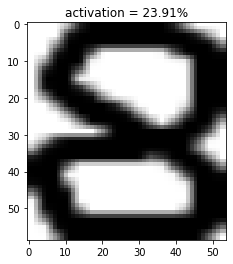

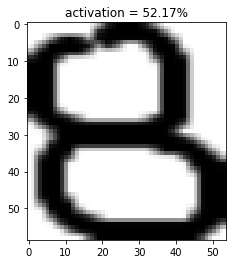

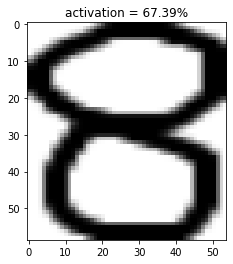

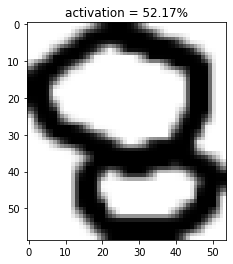

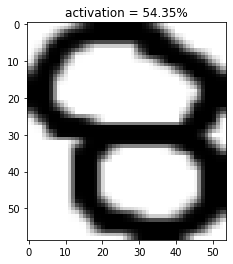

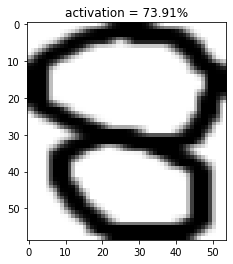

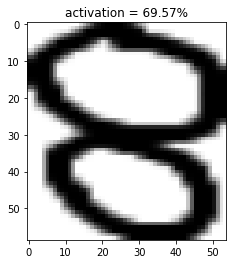

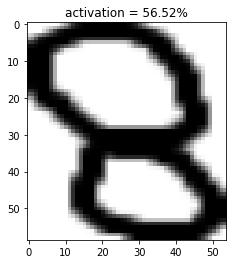

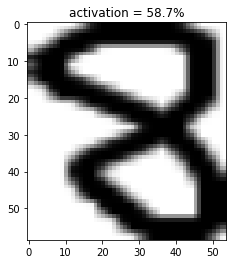

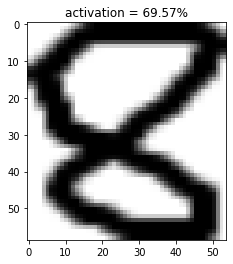

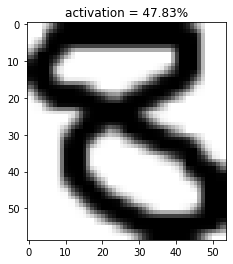

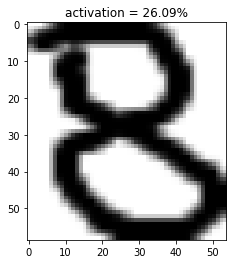

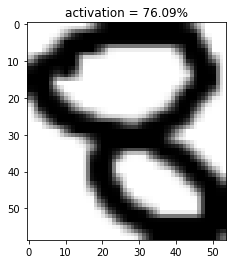

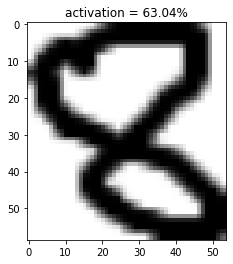

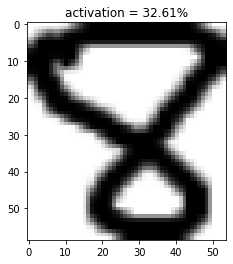

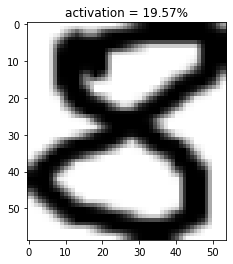

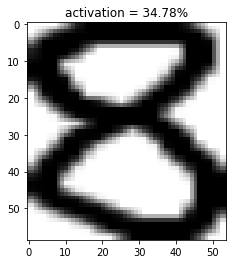

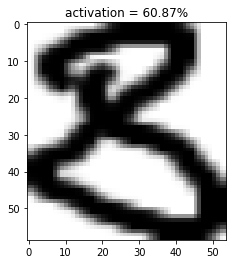

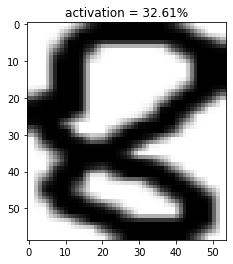

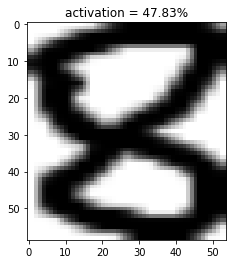

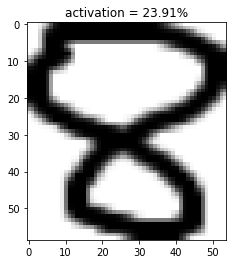

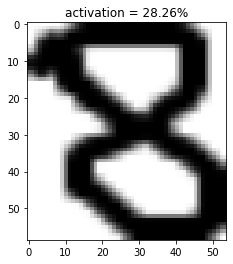

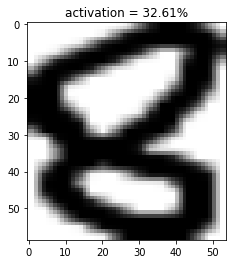

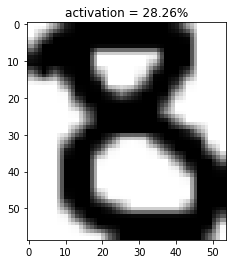

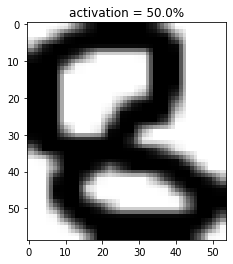

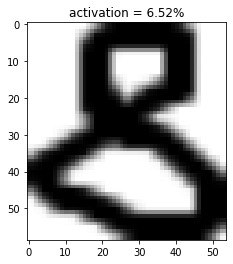

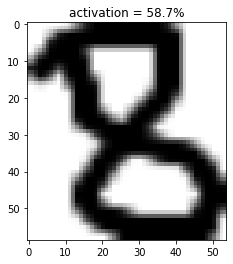

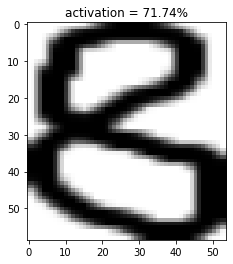

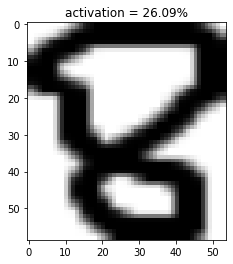

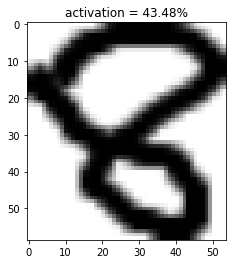

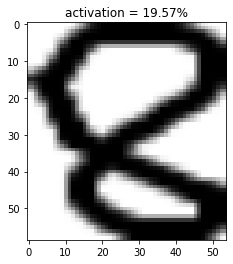

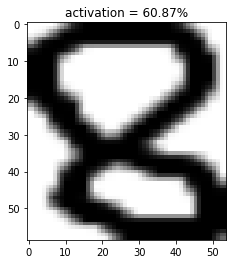

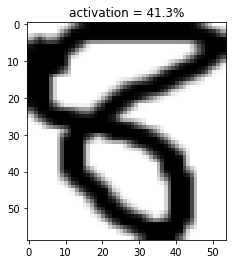

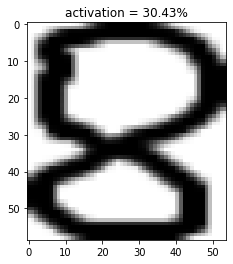

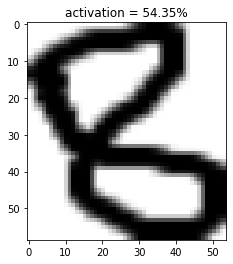

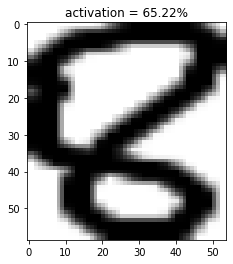

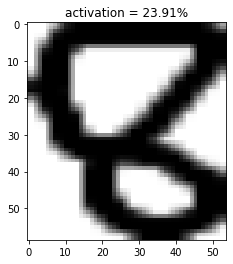

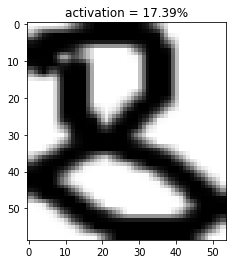

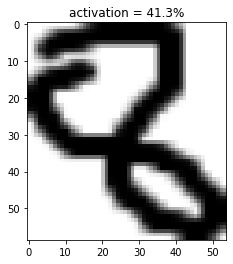

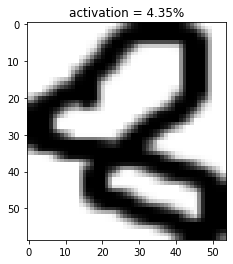

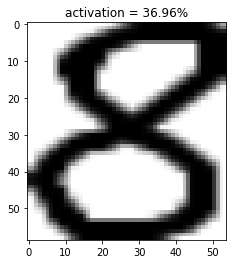

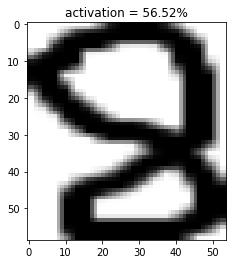

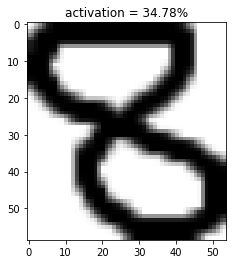

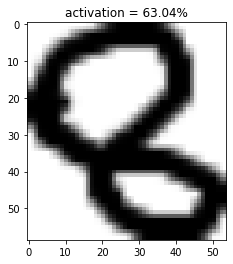

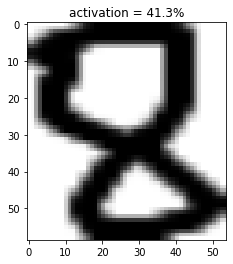

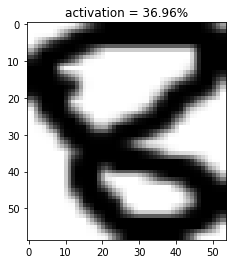

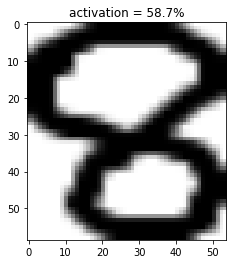

In [23]:
corrTres = 0.001

testingClassIndex = 9
#getting the best processes set for this data set
isBestProcesses = isBestProcesses_ALL[testingClassIndex]
bestProcesses = []
bestParams = []
for filterIndex in range(len(filters)):
    for featureTresIndex in range(len(featureTresVals)):
        if isBestProcesses[filterIndex][featureTresIndex]:
            bestProcesses.append([filters[filterIndex],featureTresVals[featureTresIndex]])
            bestParams.append(params_ALL[testingClassIndex][filterIndex][featureTresIndex])
            

totalBestProcessesCount = len(bestProcesses)
testingDataFileFolder =r"D:/ENTC/SEM_4/EN2550 - Fundamentals of Image Processing and Machine Vision/~images/int-rec/8/"
testingFiles = os.listdir(testingDataFileFolder)



for fileIndex in range(len(testingFiles)):
    noOfTotalActivationsFromBest_proc_params = 0
    filePath = testingDataFileFolder + testingFiles[fileIndex]
    dataImg = cv.imread(filePath,0)
    assert dataImg is not None
    dataImg = focusToContent(dataImg)
    dataImg = dataImg.astype(np.float32)
    
    #r3ki3g
    #dataImg = cv.GaussianBlur(dataImg,(5,5),4) #blured after seeing the feature-detection-filtering
    
    

    
    
    
    for bestProcessIndex in range(len(bestProcesses)):
        thisBestProcess = bestProcesses[bestProcessIndex]
        thisFilter = thisBestProcess[0]
        featureTres = thisBestProcess[1]
        

        #the parameter (2D) for this process (consisting by this kernel and treshold)
        parameter2D = bestParams[bestProcessIndex] #normalized,averageZeroed
        #r3ki3g
        parameter2D = cv.GaussianBlur(parameter2D,(7,7),4)


        filtered = cv.filter2D(dataImg,-1,thisFilter)
        #r3ki3g
        filtered = cv.GaussianBlur(filtered,(5,5),4)
        thresholderMask = filtered > np.max(filtered) * featureTres
        thresholdedResult = filtered*thresholderMask
        thresholdedResultNorm = thresholdedResult / np.sum(thresholdedResult)#normalizing
        thresholdedResultNormAVGZERO = thresholdedResultNorm - np.mean(thresholdedResultNorm) #averageZeroing
        correlation = np.sum(thresholdedResultNormAVGZERO*parameter2D)
       
        activated = correlation > corrTres
        if activated:
            noOfTotalActivationsFromBest_proc_params+=1
    fig,ax = plt.subplots()
    ax.imshow(dataImg,cmap=cmap)
    ax.set_title("activation = " + str(round(100*noOfTotalActivationsFromBest_proc_params/totalBestProcessesCount,2)) + "%")
    plt.show()
        
   

## Summary 

Now it is able to draw a lines among<br/>


### Records
Keeping kernel sizes,kernel count and threshold values of each result to see whether how those selections affect the classification process